### Bayesian Data Analysis, 3rd edition
##  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

The original notebook (before I did the exercise) is [here](https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch3/demo3_6.ipynb).

In [1]:
import numpy as np
from scipy.special import expit  # aka logistic
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys

util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import plot_tools

plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

rng = np.random.RandomState(0)

In [2]:
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

For Biosassy we have 4 experiments and for the $i$th experiment:

* $y_i$: the number of deaths
* $n_i$: the number of animals tested
* $x_i$: the log of the dose amount (g/ml), an explanatory variable. 

We can thus set this up as a logistic regression model with:

$$ y_i \mid \theta_i \sim \text{Bin}(n_i, \theta_i)$$

and 

$$ \text{logit}(\theta_i) = \alpha + \beta x_i$$

so 

$$ \theta_i = \sigma(\alpha + \beta x_i)$$

with $\sigma$ being the inverse-logit/sigmoid function.

This means we can write the likelihood in terms of $\alpha$ and $\beta$ as:

$$y_i \mid \alpha, \beta, n_i, x_i \propto [\sigma(\alpha + \beta x_i)]^{y_i} \, [1- \sigma(\alpha + \beta x_i)]^{n_i - y_i}$$

and initially we assume a prior such that:

$$p(\alpha, \beta) \propto 1$$

For Ex 3.11 we use a different prior which is a joint normal distribution over $\alpha$ and $\beta$:

$$\alpha \sim \mathcal{N}(0, 2^2)$$ and $$\beta \sim \mathcal{N}(10, 10^2)$$ and $\rho_{\alpha, \beta} = 0.5$ as the correlation between $\alpha$ and $\beta$.

Let's plot the data:

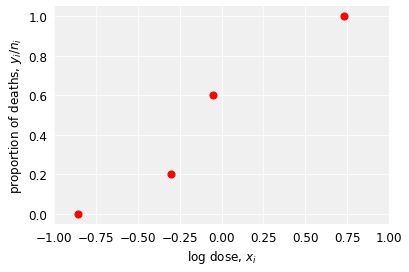

In [3]:
plt.scatter(x, y/n, 50, color='red')
plt.xlim((-1, 1))
plt.xlabel(f'log dose, $x_i$')
plt.ylabel('proportion of deaths, $y_i/n_i$');

### Look at prior

In [4]:
mu_alpha = 0
mu_beta = 0
sd_alpha = 2
sd_beta = 10
corr = 0.5
cov = np.array([[sd_alpha**2, sd_alpha*sd_beta*corr], [sd_alpha*sd_beta*corr, sd_beta**2]])
prior = stats.multivariate_normal(mean=[mu_alpha, mu_beta], cov=cov)

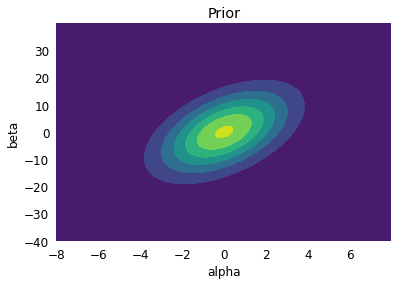

In [5]:
alpha_min, alpha_max = -8, 8
beta_min, beta_max = -40, 40
alpha_grid, beta_grid = np.mgrid[alpha_min:alpha_max:.05, beta_min:beta_max:.1]
prior_grid = np.dstack((alpha_grid, beta_grid))

prior_pdf = prior.pdf(prior_grid)
prior_logpdf = prior.logpdf(prior_grid)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(alpha_grid, beta_grid, prior_pdf);
ax.set_xlabel("alpha");
ax.set_ylabel("beta");
ax.set_title("Prior");

### Compute log-posterior over a grid

We will define a grid of values for $\alpha$ and $\beta$ and evaluate the (unnormalized) log-posterior at each point in it. By using the log-posterior we turn products into sums.

Setting the `add_mvnorm_prior` flag to `False` is equivalent to assuming that: $p(\alpha, \beta) \propto 1$.

In [6]:
add_mvnorm_prior = True
add_mvnorm_flag = 1 if add_mvnorm_prior else 0

We can work out the log-likelihood from above as:

$$\mathcal{LL} = -(n_i - y_i)(\alpha + \beta x_i) - n_i \log[1 + \exp^{-(\alpha + \beta x_i)}]$$

In [7]:
def calculate_posterior(alpha_grid, beta_grid, x, use_prior):
    add_mvnorm_flag = 1 if use_prior else 0 
    
    abx = alpha_grid[:, :, None] + beta_grid[:, :, None] * x
    ilogit_abx = 1 / (np.exp(-abx) + 1)
    likelihood = ilogit_abx**y * (1 - ilogit_abx)**(n - y)
    log_likelihood = -(n - y)*(abx) - n*np.log(1 + np.exp(-abx))
    joint_log_likelihood = log_likelihood.sum(2)
    joint_likelihood = np.prod(likelihood, axis=2)

    joint_log_posterior = joint_log_likelihood + prior_logpdf * add_mvnorm_flag
    posterior = np.exp(joint_log_posterior - joint_log_posterior.max()) if use_prior else joint_likelihood
    return posterior

In [30]:
def summarise_array(arr, q = [0.05, 0.25, 0.5, 0.75, 0.95]):
    print(f"Mean: {np.mean(arr):.4f}")
    for x in q:
        print(f"{x:.2f}: {np.quantile(arr, x):.4f}")

In [69]:
posterior = calculate_posterior(alpha_grid, beta_grid, x, use_prior=True)

Sample from the posterior:

In [70]:
nsamp = 2500
samp_indices = np.unravel_index(
    rng.choice(posterior.size, size=nsamp, p=posterior.ravel()/np.sum(posterior)),
    posterior.shape
)

samp_A_raw = alpha_grid[samp_indices[0], samp_indices[1]]
samp_B_raw = beta_grid[samp_indices[0], samp_indices[1]]

# Jitter a bit:
samp_A = samp_A_raw + (np.random.rand(len(samp_A_raw)) - 0.5)/10
samp_B = samp_B_raw + (np.random.rand(len(samp_B_raw)) - 0.5)/10

In [71]:
summarise_array(samp_A_raw)

Mean: 0.9413
0.05: -0.3500
0.25: 0.3500
0.50: 0.8500
0.75: 1.4500
0.95: 2.4500


In [72]:
summarise_array(samp_B_raw)

Mean: 8.6828
0.05: 3.5000
0.25: 5.7000
0.50: 8.1000
0.75: 11.1000
0.95: 15.8000


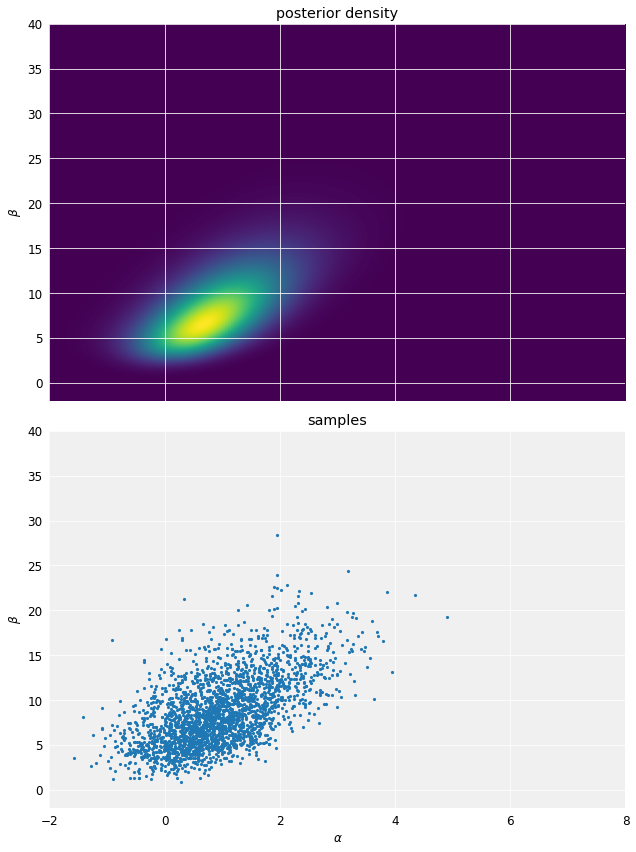

In [73]:
x_min, x_max = -2, 8
y_min, y_max = -2, 40
    
# create figure
fig, axes = plt.subplots(2, 1, figsize=(9, 12), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(posterior.T, 
          origin='lower', 
          aspect='auto', 
          extent=(alpha_min, alpha_max, beta_min, beta_max)
         )
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, 
           samp_B, 
           10, linewidth=0, alpha=1)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

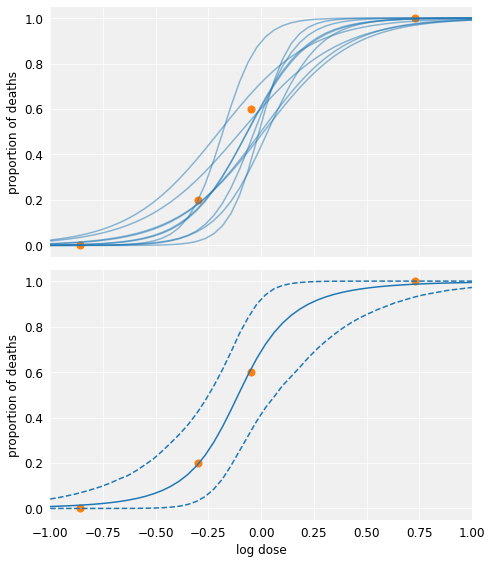

In [74]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

In [75]:
# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]
print(f"{np.mean(bpi):.2f}")

1.00


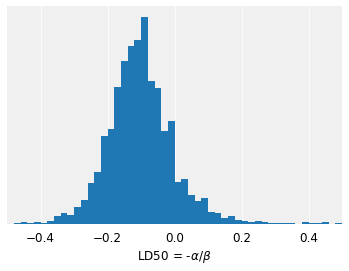

In [76]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());